# Spotify Songs & Behaviors

This project will have students dive into recommender systems in one of their most prevalent applications, song recommendations. This dataset contains over 56GB of data on user behavior on Spotify, a popular music service. In addition, you are provided with song attribute data computed using Spotify’s deep learning algorithms to aid in the system. The task is to predict, given a user and a song, whether they will play through or skip the song.

Keywords: audio data, recommender systems, reinforcement learning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
import os

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

### EDA

In [3]:
train_df = pd.read_csv('data/training_set/log_mini.csv')
pd.set_option('display.max_columns', None) # display all columns

train_df = train_df.rename(columns = {'track_id_clean':'track_id'})
track_df = pd.read_csv('data/track_features/tf_mini.csv')

df = pd.merge(train_df,track_df,on='track_id',how='left')
df.head()

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,3.484468e-03,1,0.678553,-6.577,0.546784,major,0.320668,0.069717,134.024994,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,1.031315e-07,7,0.104322,-5.319,0.824766,minor,0.131391,0.061158,130.037994,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,231.266663,2018,99.999976,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,1.029465,2.659035e-08,10,0.135776,-5.843,0.774327,major,0.296923,0.045354,145.028000,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,169.826675,2018,99.995038,0.769225,0.641756,0.729224,0.864881,11.287586,0.529484,0.993520,6.598388e-06,1,0.103722,-7.756,0.630996,major,0.603271,0.229936,111.982002,4,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,210.545258,2018,99.998498,0.006602,0.732428,0.794881,0.857778,12.181586,0.650057,1.000571,2.066649e-06,8,0.120842,-4.919,0.759465,major,0.170148,0.240980,147.031006,4,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315


In [4]:
#df['date'] = pd.to_datetime(df['date'])

In [5]:
df[['skip_1','skip_2','skip_3','not_skipped']].mean()

skip_1         0.421503
skip_2         0.517179
skip_3         0.648380
not_skipped    0.332881
dtype: float64

In [6]:
def get_pause(df):
    if df['no_pause_before_play'] == 1:
        return 'no'
    elif df['short_pause_before_play'] == 1:
        return 'short'
    elif df['long_pause_before_play'] == 1:
        return 'long'
pause = df.apply(get_pause, axis = 1)
df = df.assign(pause_before_play = pause)

In [7]:
df.groupby('pause_before_play')[['skip_1','skip_2','skip_3','not_skipped']].mean()

,skip_1,skip_2,skip_3,not_skipped
pause_before_play,,,,
long,0.119145,0.212824,0.449068,0.510005
no,0.473519,0.546099,0.631351,0.353688
short,0.267579,0.476987,0.783727,0.188528


In [8]:
df.groupby('premium')[['skip_1','skip_2','skip_3','not_skipped']].mean()

,skip_1,skip_2,skip_3,not_skipped
premium,,,,
False,0.449147,0.533761,0.652936,0.330254
True,0.415037,0.513300,0.647314,0.333495


In [9]:
df.groupby(['premium','hist_user_behavior_is_shuffle'])[['skip_1','skip_2','skip_3','not_skipped']].mean()

skip_1    skip_2    skip_3  \
premium hist_user_behavior_is_shuffle                                 
False   False                          0.467550  0.550189  0.669840   
        True                           0.376074  0.468530  0.585819   
True    False                          0.386445  0.487035  0.628517   
        True                           0.472076  0.565699  0.684813   

                                       not_skipped  
premium hist_user_behavior_is_shuffle               
False   False                             0.312815  
        True                              0.399500  
True    False                             0.350926  
        True                              0.298721

In [10]:
df.groupby('hist_user_behavior_reason_start')[['skip_1','skip_2','skip_3','not_skipped']].mean()

,skip_1,skip_2,skip_3,not_skipped
hist_user_behavior_reason_start,,,,
appload,0.249228,0.459320,0.766220,0.175077
backbtn,0.641630,0.685515,0.758478,0.225180
clickrow,0.240379,0.378554,0.580279,0.381809
endplay,0.200000,0.400000,0.550000,0.100000
fwdbtn,0.684653,0.764841,0.845718,0.143458
playbtn,0.264516,0.483871,0.645161,0.329032
remote,0.264706,0.441176,0.816176,0.110294
trackdone,0.052165,0.164485,0.353191,0.623786
trackerror,0.423913,0.489130,0.608696,0.380435


In [11]:
df.groupby('hist_user_behavior_reason_end')[['skip_1','skip_2','skip_3','not_skipped']].mean()

,skip_1,skip_2,skip_3,not_skipped
hist_user_behavior_reason_end,,,,
backbtn,0.813695,0.899916,0.987661,0.004037
clickrow,0.875000,1.000000,1.000000,0.000000
endplay,0.290360,0.577211,0.947109,0.015112
fwdbtn,0.682586,0.809987,0.982307,0.002298
logout,0.113677,0.289520,0.936057,0.012433
remote,0.205993,0.453184,0.973783,0.003745
trackdone,0.001629,0.004107,0.019064,0.960330


In [12]:
df.groupby('context_type')[['skip_1','skip_2','skip_3','not_skipped']].mean()

,skip_1,skip_2,skip_3,not_skipped
context_type,,,,
catalog,0.345059,0.456525,0.609309,0.371063
charts,0.451454,0.555100,0.684965,0.300287
editorial_playlist,0.402490,0.508174,0.640131,0.341839
personalized_playlist,0.331989,0.452285,0.632392,0.350470
radio,0.449282,0.553750,0.681196,0.303454
user_collection,0.469109,0.546404,0.664022,0.316091


In [13]:
def get_skip(df):
    if df['not_skipped'] == 1:
        return 'not skipped'
    else: 
        return 'skipped'
skip_info = df.apply(get_skip, axis = 1)
df = df.assign(skip_type = skip_info)

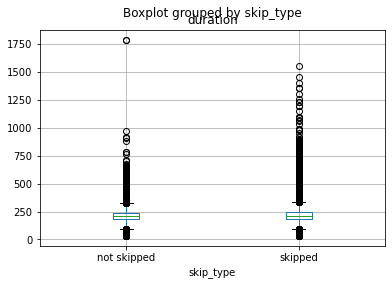

In [14]:
df.boxplot(column = 'duration', by = 'skip_type')

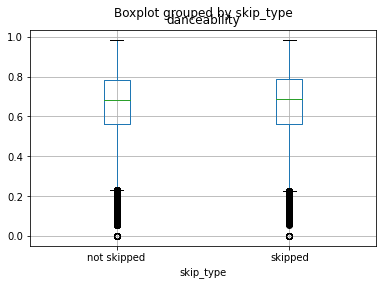

In [15]:
df.boxplot(column = 'danceability', by = 'skip_type')

#### Baseline Model

In [16]:
df.shape

(167880, 52)

In [17]:
df.head()

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,pause_before_play,skip_type
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,3.484468e-03,1,0.678553,-6.577,0.546784,major,0.320668,0.069717,134.024994,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826,None,not skipped
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,1.031315e-07,7,0.104322,-5.319,0.824766,minor,0.131391,0.061158,130.037994,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920,no,not skipped
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,231.266663,2018,99.999976,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,1.029465,2.659035e-08,10,0.135776,-5.843,0.774327,major,0.296923,0.045354,145.028000,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604,no,not skipped
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,169.826675,2018,99.995038,0.769225,0.641756,0.729224,0.864881,11.287586,0.529484,0.993520,6.598388e-06,1,0.103722,-7.756,0.630996,major,0.603271,0.229936,111.982002,4,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603,no,not skipped
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,210.545258,2018,99.998498,0.006602,0.732428,0.794881,0.857778,12.181586,0.650057,1.000571,2.066649e-06,8,0.120842,-4.919,0.759465,major,0.170148,0.240980,147.031006,4,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315,no,not skipped


In [18]:
X = df.drop(['session_id','track_id', 'session_position', 'session_length','skip_1','skip_2','skip_3', 'not_skipped', 'hist_user_behavior_reason_end','pause_before_play','skip_type'], axis = 1)
y = df['skip_type']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [19]:
ct = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=False), 
     ['mode', 
      'date', 
      'context_type', 
      'hist_user_behavior_reason_start'])], remainder = 'passthrough')
pl = Pipeline([('feats', ct), ('clf', DecisionTreeClassifier())])
pl.fit(X_train, y_train)

Pipeline(steps=[('feats',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['mode', 'date',
                                                   'context_type',
                                                   'hist_user_behavior_reason_start'])])),
                ('clf', DecisionTreeClassifier())])

In [20]:
print(pl.score(X_train, y_train), pl.score(X_test, y_test))

0.9854260980065126 0.7154395997140814


[0.00513878 0.0137619  0.01679043 0.00918184 0.00709623 0.01578308
 0.0113537  0.11109231 0.02231317 0.01135066 0.02944399 0.28493198
 0.01775086 0.01615324 0.01624464 0.01706648 0.01627508 0.01611925
 0.01634071 0.01630753 0.01685603 0.01665933 0.01472201 0.01670289
 0.01710822 0.01687834 0.01662464 0.00860146 0.01633073 0.0168856
 0.01703105 0.00551233 0.01701151 0.01665808 0.01652078 0.01636152
 0.01656482 0.01646631 0.01669512 0.01680896 0.01650442]


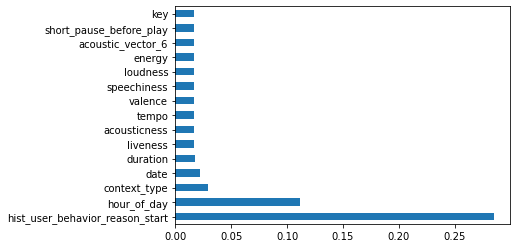

In [21]:
cat_columns = ['mode', 
      'date', 
      'context_type', 
      'hist_user_behavior_reason_start']
X2 = X.copy()
le = LabelEncoder()
X2[cat_columns] = X2[cat_columns].apply(le.fit_transform)
model = ExtraTreesClassifier()
model.fit(X2,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [22]:
X2 = df[['duration', 'context_type', 'hour_of_day',
        'no_pause_before_play', 'hist_user_behavior_reason_start', 
         'date', 'liveness', 'acousticness', 'valence', 'tempo']]

X2_train, X2_test, y_train, y_test = train_test_split(X2, y)

ct = ColumnTransformer([
    ('cat', OneHotEncoder(sparse=False), 
     [ 'context_type', 
      'hist_user_behavior_reason_start', 'date'])], remainder = 'passthrough')

pl = Pipeline([('feats', ct), ('clf', DecisionTreeClassifier())])
pl.fit(X2_train, y_train)

Pipeline(steps=[('feats',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['context_type',
                                                   'hist_user_behavior_reason_start',
                                                   'date'])])),
                ('clf', DecisionTreeClassifier())])

In [23]:
print(pl.score(X2_train, y_train), pl.score(X2_test, y_test))

0.973743149868954 0.6977364784369788


#### Tone parameters

In [24]:
parameters = {
    'clf__max_depth': [2,3,4,5,7,10,13,15,18,None], 
    'clf__min_samples_leaf':[2,3,5,7,10,15,20],
    'clf__min_samples_split':[2,3,5,7,10,15,20]
}

In [25]:
clf = GridSearchCV(pl, parameters, cv = 5)
clf.fit(X2_train, y_train)
clf.best_params_

{'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}

In [46]:
pl2 = Pipeline([('feats', ct), ('clf', DecisionTreeClassifier(max_depth = 2, min_samples_leaf = 2, min_samples_split = 2))])
pl2.fit(X2_train, y_train)

Pipeline(steps=[('feats',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse=False),
                                                  ['context_type',
                                                   'hist_user_behavior_reason_start',
                                                   'date'])])),
                ('clf',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=2))])

In [47]:
print(pl2.score(X2_train, y_train), pl2.score(X2_test, y_test))

0.8016440314510365 0.8020014295925662


#### Test model using the full dataset

The major finding from this section is that, for the full dataset, the decision tree model without parameter toning has a higher performance (90% accuracy) than the model with parameter toning(80%).

In [24]:
spark = SparkSession.builder.getOrCreate()
spark_fp = os.path.join("track_features", "tf_000000000000.csv")
spark_df = spark.read.load(spark_fp, format="csv", inferSchema="true", header="true")
spark_df.count()

1853311

In [28]:
track_df_2 = spark_df.limit(1000000).toPandas()
track_df_2.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,326.013336,1971,99.582885,0.716209,0.366495,0.332605,0.439835,5.805774,0.238847,1.010700,6.533861e-01,0,0.769258,-17.094,0.199170,major,0.759699,0.033940,100.370003,4,0.223395,0.146012,-0.706908,0.259496,0.481157,0.238427,-0.098389,-0.254960,-0.227383
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,147.813324,1963,97.272035,0.839460,0.362212,0.389829,0.507580,6.845427,0.420476,1.000398,3.941550e-09,0,0.085844,-11.295,0.357639,major,0.747436,0.049856,141.334000,4,0.484702,0.039554,-0.539554,0.105141,0.692589,0.226047,-0.468162,0.164389,-0.769024
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,110.400002,1974,99.620384,0.054673,0.495002,0.589378,0.552311,9.361949,0.842938,0.957766,1.041595e-01,0,0.407325,-9.310,0.304721,major,0.493154,0.071753,138.889999,4,0.818441,0.083863,-0.242108,-0.014258,0.096396,0.417641,-0.050576,-0.204757,-0.172563
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,237.653336,1988,96.796830,0.042606,0.389634,0.359044,0.585673,6.068578,0.665398,0.947322,1.444963e-05,0,0.251502,-12.159,0.702948,major,0.212197,0.029425,133.139008,4,0.594829,0.192498,0.340039,0.034846,-0.389794,0.518381,0.185008,-0.079907,-0.016978
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,174.600006,1987,97.905891,0.249982,0.513640,0.485435,0.635095,7.198735,0.408715,1.014063,5.266880e-01,0,0.218370,-13.813,0.888889,major,0.193438,0.032178,152.212006,4,0.591289,0.270586,-0.411061,0.165898,0.225652,0.335518,-0.036643,-0.016300,-0.446870


In [55]:
df_2 = pd.merge(train_df,track_df_2,on='track_id')

In [57]:
skip_info_2 = df_2.apply(get_skip, axis = 1)
df_2 = df_2.assign(skip_type = skip_info_2)

In [58]:
X3_test = df_2[['duration', 'context_type', 'hour_of_day',
        'no_pause_before_play', 'hist_user_behavior_reason_start', 
         'date', 'liveness', 'acousticness', 'valence', 'tempo']]
y3_test = df_2[['skip_type']]
pl.score(X3_test, y3_test)

0.9004167232866784

In [59]:
pl2.score(X3_test, y3_test)

0.797141821805499

In [60]:
spark_fp_2 = os.path.join("track_features", "tf_000000000001.csv")
spark_df_2 = spark.read.load(spark_fp_2, format="csv", inferSchema="true", header="true")
track_df_3 = spark_df_2.limit(1000000).toPandas()

In [61]:
df_3 = pd.merge(train_df,track_df_3,on='track_id')

In [63]:
skip_info_3 = df_3.apply(get_skip, axis = 1)
df_3 = df_3.assign(skip_type = skip_info_3)

In [64]:
X4_test = df_3[['duration', 'context_type', 'hour_of_day',
        'no_pause_before_play', 'hist_user_behavior_reason_start', 
         'date', 'liveness', 'acousticness', 'valence', 'tempo']]
y4_test = df_3[['skip_type']]
pl.score(X4_test, y4_test)

0.9060972588237944

In [65]:
pl2.score(X4_test, y4_test)

0.8047841070342591